### $\text {Import libraries}$

In [ ]:
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from keras.datasets import cifar10
from torch.optim import SGD, AdamW
from torchvision import transforms
from sklearn.metrics import accuracy_score
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

In [ ]:
custom = {"axes.edgecolor": "black", "grid.linestyle": "dashed", "grid.color": "gray"}
sns.set_style("darkgrid", rc = custom)

In [ ]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 13s 0us/step


### $\text {In this file I want to implement the structure of the AlexNet network}$

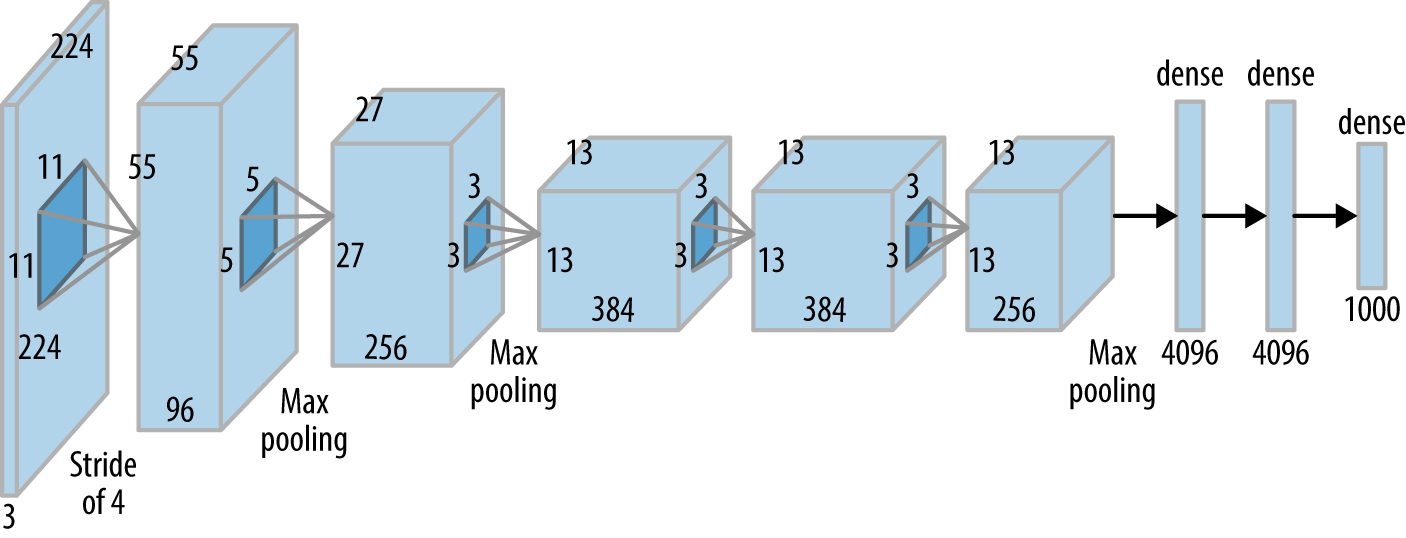

In [ ]:
def plot_img(img, label):
    fig = plt.figure(figsize=(4, 4))
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.title(label)

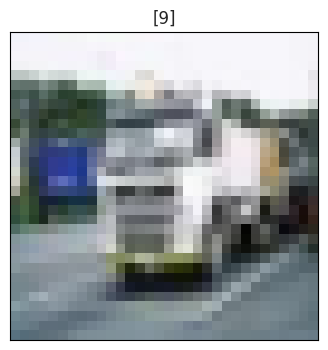

In [ ]:
plot_img(X_train[1000], y_train[1000])

### $\text {Making CIFAR10 Dataset class for our data}$

In [ ]:
class CIFAR10(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X.transpose((0, 3, 1, 2)) / 255.).type(torch.float32)
        self.y = torch.from_numpy(y)
        self.preprocess = transforms.Compose([
            transforms.Resize((227, 227)),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    # Перегружаем метод, который возвращает объект из X_train и его метку из y_test по индексу
    def __getitem__(self, index):
        return self.preprocess(self.X[index]), self.y[index]

    # Перегружаем метод, который позволяет узнать длину датасета
    def __len__(self):
        return len(self.X)

In [ ]:
train_data = CIFAR10(X_train, y_train)
test_data = CIFAR10(X_test, y_test)

In [ ]:
train_loader = DataLoader(train_data, 64, shuffle=True)
test_loader = DataLoader(test_data, 64)

### $\text {Making our AlexNet architecture}$

In [ ]:
class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()

        self.layer_1 = nn.Sequential(
            nn.Conv2d(
                in_channels=3,
                out_channels=96,
                kernel_size=11,
                stride=4
            ),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        self.layer_2 = nn.Sequential(
            nn.Conv2d(
                in_channels=96,
                out_channels=256,
                kernel_size=5,
                stride=1,
                padding = 2
            ),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        self.layer_3 = nn.Sequential(
            nn.Conv2d(
                in_channels=256,
                out_channels=384,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.BatchNorm2d(384),
            nn.ReLU()
        )
        self.layer_4 = nn.Sequential(
            nn.Conv2d(
                in_channels=384,
                out_channels=384,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.BatchNorm2d(384),
            nn.ReLU()
        )
        self.layer_5 = nn.Sequential(
            nn.Conv2d(
                in_channels=384,
                out_channels=256,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )

        self.fc_1 = nn.Sequential(
            nn.Linear(9216, 4096),
            nn.ReLU(),
            nn.Dropout(0.5)
        )
        self.fc_2 = nn.Sequential(
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(0.5)
        )
        self.fc_3 = nn.Sequential(
            nn.Linear(4096, 10)
        )


    def forward(self, x):
        x = self.layer_1(x)
        x = self.layer_2(x)
        x = self.layer_3(x)
        x = self.layer_4(x)
        x = self.layer_5(x)
        x = x.flatten(start_dim=1)
        x = self.fc_1(x)
        x = self.fc_2(x)
        x = self.fc_3(x)
        return x

In [ ]:
# Это нужно для выбора устройства, на котором мы будем обучать. 'cuda' - видеокарта
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
model = AlexNet().to(device=device)

In [ ]:
# Это метод оптимизации loss-function
optimizer = SGD(model.parameters(), lr=0.005, weight_decay = 0.005, momentum = 0.9) # weight_decay - это параметр, отвечающий за максимальное изменение весов
                                                                                    # momentum - значение энерции
# Это наш лосс
criterion = nn.CrossEntropyLoss()

In [ ]:
epochs = 20

### $\text {Trainig process}$

In [ ]:
model.train()

for epoch in range(epochs):
    epoch_losses = []
    for batch in tqdm(train_loader):

        # Распаковываем батч
        X_batch, y_batch = batch
        # Делаем forward pass
        out = model(X_batch.to(device=device))
        # Считаем loss
        loss = criterion(out.cpu(), y_batch.squeeze())
        # Обнуляем все градиенты для того, чтобы градиенты обнулялись в каждом батче
        optimizer.zero_grad()
        # Делаем backward pass, чтобы посчитать градиенты
        loss.backward()
        # Делаем шаг в сторону анти-градиента
        optimizer.step()

        epoch_losses.append(loss.item())
    print(np.mean(epoch_losses))

100%|██████████| 782/782 [01:31<00:00,  8.55it/s]


1.3725886950102608


100%|██████████| 782/782 [01:29<00:00,  8.74it/s]


0.9499838043509237


100%|██████████| 782/782 [01:31<00:00,  8.51it/s]


0.7819927178532876


100%|██████████| 782/782 [01:31<00:00,  8.55it/s]


0.6870260077059421


100%|██████████| 782/782 [01:33<00:00,  8.41it/s]


0.6117688030995372


100%|██████████| 782/782 [01:31<00:00,  8.54it/s]


0.5584341057807284


100%|██████████| 782/782 [01:33<00:00,  8.36it/s]


0.5069374988794022


100%|██████████| 782/782 [01:30<00:00,  8.66it/s]


0.47015838315496056


100%|██████████| 782/782 [01:32<00:00,  8.46it/s]


0.44130173457019467


100%|██████████| 782/782 [01:31<00:00,  8.54it/s]


0.41418883541737067


100%|██████████| 782/782 [01:30<00:00,  8.66it/s]


0.38868098046697314


100%|██████████| 782/782 [01:30<00:00,  8.66it/s]


0.37531221316903446


100%|██████████| 782/782 [01:29<00:00,  8.73it/s]


0.3551968154699906


100%|██████████| 782/782 [01:29<00:00,  8.73it/s]


0.3409048228731851


100%|██████████| 782/782 [01:30<00:00,  8.65it/s]


0.33066978868659197


100%|██████████| 782/782 [01:30<00:00,  8.64it/s]


0.3110262243186726


100%|██████████| 782/782 [01:56<00:00,  6.71it/s]


0.3016129952314717


100%|██████████| 782/782 [01:56<00:00,  6.69it/s]


0.28930128872623223


100%|██████████| 782/782 [01:57<00:00,  6.68it/s]


0.29206352285526294


100%|██████████| 782/782 [01:56<00:00,  6.72it/s]

0.2816960343809994


### $\text {Inference}$

In [ ]:
model.eval()

accuracies = []

for batch in test_loader:
    with torch.no_grad():
        out = model(batch[0].to(device))
    predictions = out.argmax(axis=-1)
    accuracies.append(accuracy_score(predictions.cpu(), batch[1]))

print(f'Accuracy = {np.mean(accuracies)}')

Accuracy = 0.8049363057324841
